# Klassificering av känslor med CNN och Keras

**Introduktion**

I detta arbete undersöks hur vi i realtid kan klassificera ansiktsuttryck för att identifiera om någon exempelvis är glad, arg eller ledsen. Målet är att bygga en känslodetektor med hjälp av en modell baserad på CNN (Convolutional Neural Network) och Keras, som via datorns webbkamera kan avgöra vilken känsla personen i bild visar. Arbetet utgår från en redan existerande modell skapad av Akshit Madan, vars kod finns tillgänglig på hans [Github](https://github.com/akmadan/Emotion_Detection_CNN).

Initialt försökte jag få den ursprungliga koden att fungera, vilket lyckades, men modellen predikterade endast känslan neutral. För att möjliggöra detektering av fler känslouttryck genomförde jag förändringar i koden där vissa delar togs bort och andra lades till.

Den slutgiltiga modellen kommer sedan att användas i ett känslodetekteringsprogram med några extra funktioner. Här följer en genomgång av arbetet, som gjorts i Google Colab, och vägen fram till det slutgiltiga resultatet.

**Översikt**
1.  Importera nödvändiga bibliotek
2.  Dataset
3.  Hämta "Face Expression Recognition Dataset"
4.  Explorativ dataanalys
5.  Tränings- och valideringsdata
6.  Skapa modell
7.  Träna modell
8.  Spara modellen och använd den
9.  Utvärdering
10. Insikter
11. Självutvärdering




# 1. Importera nödvändiga bibliotek



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile

# Deep Learning Bibliotek
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
!pip install --upgrade kaggle

# 2. Dataset
Det dataset som används i detta arbete är "Face expression recognition dataset", tillgängligt på [Kaggle](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset/code).

Datsetet är fördefinerat och uppdelat i en träningsdel och en valideringsdel. Varje del består av 7 olika kataloger där varje katalog motsvarar en specifik känsla. I varje katalog finns olika antal bilder som representerar den givna känslan. De olika känslorna som är representerade inkluderar arg, avsky, rädsla, glad, neutral, ledsen och förvånad. Totalt innehåller datasetet 35887 bilder.


# 3. Hämta "Face Expression Recognition Dataset"

In [3]:
# Ladda ner datasetet från Kaggle
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Extrahera datasetet
with zipfile.ZipFile('face-expression-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('face-expression-recognition-dataset')

# **4. Explorativ Dataanalys**

För att få en bättre förståelse för datasetet undersöktes träningsdelen av "Face Expression Recognition Dataset".

In [5]:
# Bildstorlek och sökväg till datasetet
picture_size = 48
folder_path = "face-expression-recognition-dataset/images/"

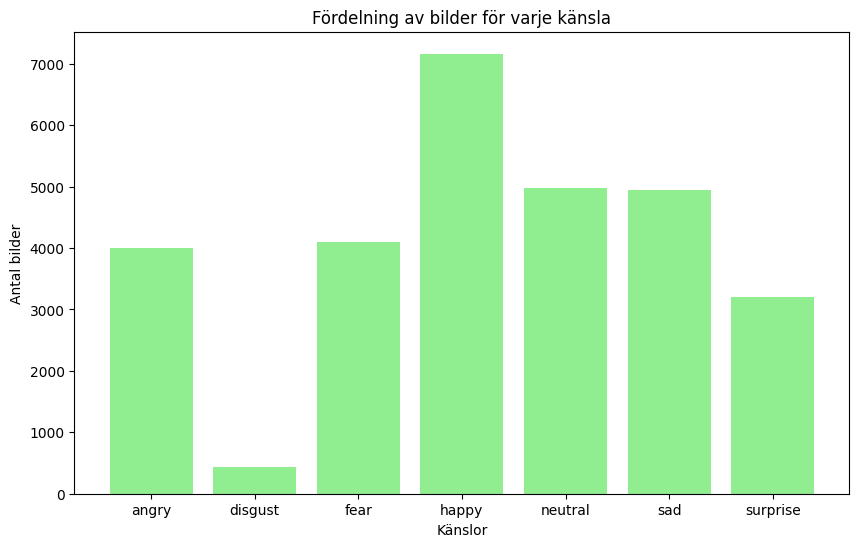

In [6]:
# Lista över olika känslor
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plotta fördelningen av bilder för varje känsla
plt.figure(figsize=(10, 6))
for i, emotion in enumerate(emotions, start=1):
    emotion_folder = os.path.join(folder_path, 'train', emotion)
    num_images = len(os.listdir(emotion_folder))
    plt.bar(emotion, num_images, color='lightgreen')

plt.xlabel('Känslor')
plt.ylabel('Antal bilder')
plt.title('Fördelning av bilder för varje känsla')
plt.show()

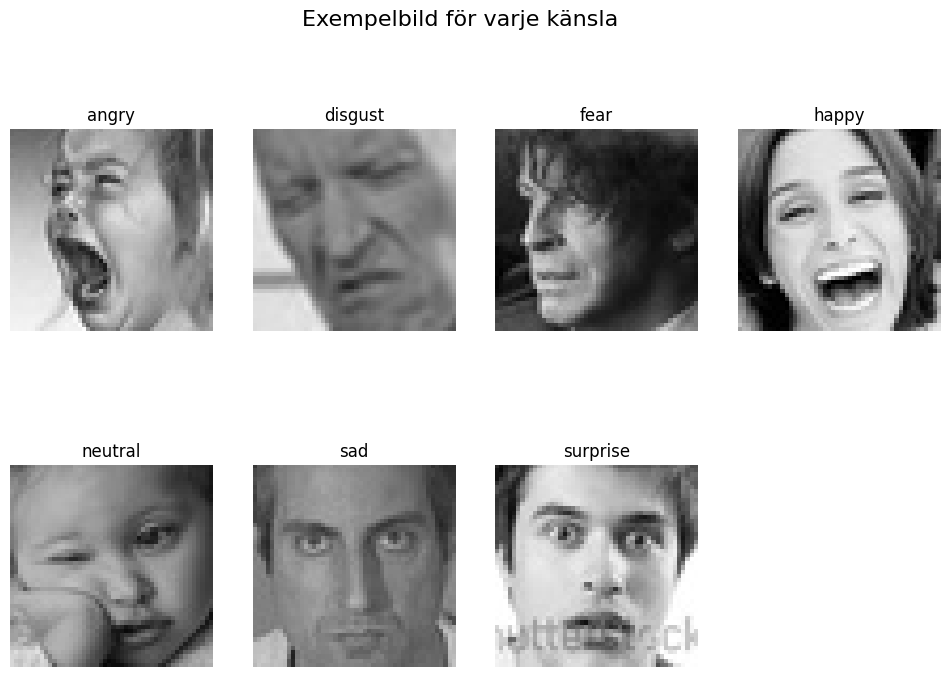

In [7]:
# Visa en exempelbild för varje känsla
plt.figure(figsize=(12, 8))
for i, emotion in enumerate(emotions, start=1):
    emotion_folder = os.path.join(folder_path, 'train', emotion)
    img_path = os.path.join(emotion_folder, os.listdir(emotion_folder)[0])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
plt.suptitle('Exempelbild för varje känsla', fontsize=16)
plt.show()

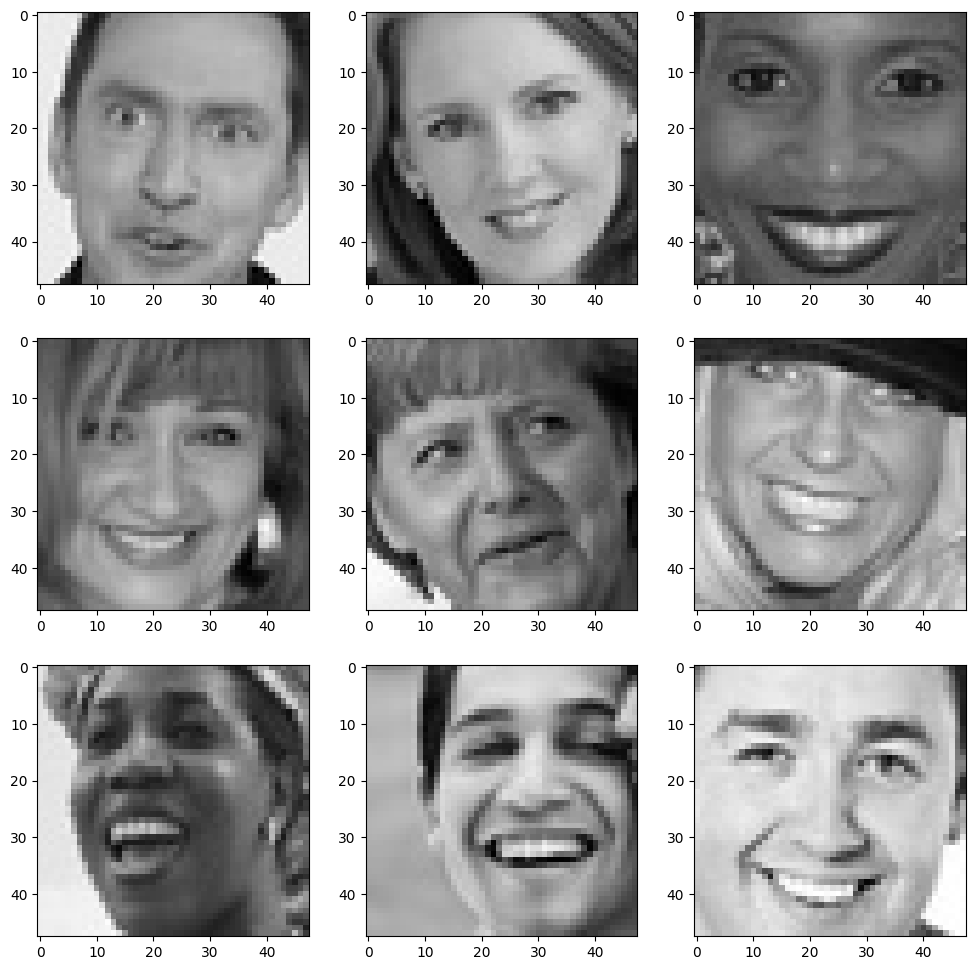

In [8]:
# Visa fler exempelbilder för känslan glad
expression = 'happy'
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

De ovanstående visualiseringarna ger flera insikter. Diagrammet som visar fördelningen av bilderna visar att datan är obalanserad. Det finns hela 7164 bilder på 'glad', medan det bara finns 436 bilder på 'avsky'. För de andra känslorna är fördelningen mer jämn. Vad kan detta ha för effekt?

Ett obalanserat dataset kan leda till att modellen blir bättre på att känna igen känslor som är överrepresenterade, som 'glad' i detta fall, medan den blir sämre på att identifiera känslor som 'avsky' som är underrepresenterade. Detta kan påverka modellens noggrannhet och förmåga att korrekt klassificera känslor.

Efter att ha granskat ett antal bilder från datasetet kan jag också konstatera att det ibland inte är helt enkelt att korrekt identifiera känslan, även för mig som människa. Detta kan ytterligare komplicera modellens inlärning och påverka dess prestanda.

# 5. Tränings- och valideringsdata

Då det aktuella datasetet redan är uppdelat i tränings- och valideringsuppsättningar krävs inget ytterligare arbete med detta. Istället för att använda en separat testuppsättning kommer modellen utvärderas med hjälp av webbkameran vilket gör det tydligt om det fungerar eller inte.

För att modellen ska kunna få tillgång till rätt data under träningsprocessen och för att utvärdera dess prestanda på valideringsdata, skapas sökvägar till respektive del av datasetet. Därefter appliceras dataaugmentering på träningsdatan för att öka variationen av träningsbilder och därigenom förbättra modellens robusthet. På valideringsdatan utförs enbart en normalisering av pixlarna i bilderna.

Tränings- och valideringsuppsättningarna skapas sedan med hjälp av Keras-funktionen flow_from_directory. Detta gör att bilderna kan matas in i modellen i batchar, storleken på bilderna anpassas och färgläget specificeras, samtidigt som kategoriklassningen och ordningen av bilderna hanteras.

In [9]:
# Sökvägar till tränings- och valideringskatalogerna
train_directory = '/content/face-expression-recognition-dataset/images/train'
val_directory = '/content/face-expression-recognition-dataset/images/validation'

# Bilddata-generator med augmentation för träningssetet
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

batch_size = 128
picture_size = 48

# Skapa tränings- och valideringsset
train_set = datagen_train.flow_from_directory(train_directory,
                                              target_size=(picture_size, picture_size),
                                              color_mode="grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

val_set = datagen_val.flow_from_directory(val_directory,
                                          target_size=(picture_size, picture_size),
                                          color_mode="grayscale",
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# 6. Skapa modell

För att bygga en modell för klassificering av ansiktsuttryck används en Convolutional Neural Network (CNN) arkitektur. Ursprungskoden är skapad av Akshit Madan och jag har endast gjort vissa justeringar för att försöka förbättra modellen. Modellen består av flera konvolutionella lager som extraherar funktioner från bilderna, följt av fullt anslutna lager. För att förhindra överanpassning har jag lagt till L2-regularisering. Dropout-lager används för att ytterligare minska överanpassning. Batchnormalisering används för att stabilisera träningen. Modellen använder Global Average Pooling för att minska antalet parametrar. Slutligen kompileras modellen med Adam-optimeraren och kategorisk korsentropiförlust för att hantera klassificeringsuppgiften med flera klasser.

In [10]:
no_of_classes = 7

model = Sequential()

# 1:a CNN-lagret
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1), kernel_regularizer='l2')) # Lagt till kernel_regularizer='l2' för att förebygga överanpassning och stabilisera träningen
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2:a CNN-lagret
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3:e CNN-lagret
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4:e CNN-lagret
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D()) # Används istället för Flatten för att minska antalet parametrar, för att förhindra överanpassning och förbättra generaliseringsförmågan

# 1:a Fullt anslutna lagret
model.add(Dense(512, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 2:a Fullt anslutna lagret
model.add(Dense(512, kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7

# 7. Träna modell

För att träna modellen för klassificering av ansiktsuttryck används olika callbacks för att optimera träningen och förhindra överanpassning. Följande kod visar hur modellen tränas med hjälp av checkpoints, early stopping och reducering av inlärningshastigheten. Jag har endast gjort några små ändringar i ett försök att förbättra träningsprocessen.

In [11]:
# Callback för att spara den bästa modellen baserat på valideringsnoggrannhet
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Callback för att stoppa träningen tidigt om valideringsförlusten inte förbättras
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5, # Ändrat från 3 för att ge modellen mer tid att förbättra sig
                          verbose=1,
                          restore_best_weights=True
                          )

# Callback för att minska inlärningshastigheten när valideringsförlusten planar ut
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Antal tränings-epoker
epochs = 50 # Ändrat från 48 för att runda av siffran och eventuellt ge modellen mer träningsmöjligheter
steps_per_epoch = train_set.n // batch_size
validation_steps = val_set.n // batch_size

In [12]:
# Träning av modellen
history = model.fit(train_set,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=validation_steps,
                    callbacks=callbacks_list)

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 16.9129 - accuracy: 0.2068
Epoch 1: val_accuracy improved from -inf to 0.17273, saving model to ./model.h5
225/225 [==============================] - 39s 125ms/step - loss: 16.9129 - accuracy: 0.2068 - val_loss: 15.2712 - val_accuracy: 0.1727 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - ETA: 0s - loss: 13.9117 - accuracy: 0.2204
Epoch 2: val_accuracy improved from 0.17273 to 0.25923, saving model to ./model.h5
225/225 [==============================] - 27s 120ms/step - loss: 13.9117 - accuracy: 0.2204 - val_loss: 12.4879 - val_accuracy: 0.2592 - lr: 1.0000e-04
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 11.2996 - accuracy: 0.2311
Epoch 3: val_accuracy improved from 0.25923 to 0.26293, saving model to ./model.h5
225/225 [==============================] - 27s 119ms/step - loss: 11.2996 - accuracy: 0.2311 - val_loss: 10.1088 - val_accuracy: 0.2629 - lr: 1.0000e-04
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 9.1360 - accuracy: 0.2381
Epoch 4: val_accuracy did not improve from 0.26293
225/225 [==============================] - 27s 118ms/step - loss: 9.1360 - accuracy: 0.2381 - val_loss: 8.1487 - val_accuracy: 0.2530 - lr: 1.0000e-04
Epoch 5/50
225/225 [===========================

# 8. Spara modellen och använd den

In [13]:
# Spara modellen till en HDF5-fil
model.save('the_final_model.h5')

In [14]:
from google.colab import files

In [15]:
# Ladda ner modellen till min lokala dator
files.download('the_final_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

För att testa och använda modellen, gå till skriptet "Emotion_Detector_with_Music_Suggestions". Modellen analyserar ditt ansiktsuttryck för att detektera din känsla. Programmet föreslår sedan en låt som matchar ditt humör och lägger till en lustig? overlay-bild.

# 9. Utvärdering

Detta avsnitt visar visualisering av tränings- och valideringsförluster samt noggrannhet över epokerna. Här visas även prediktioner på valideringsdatan och en jämförelse mellan den predikterade känslan med den sanna känslan, detta för att få en uppfattning om modellens prestanda.

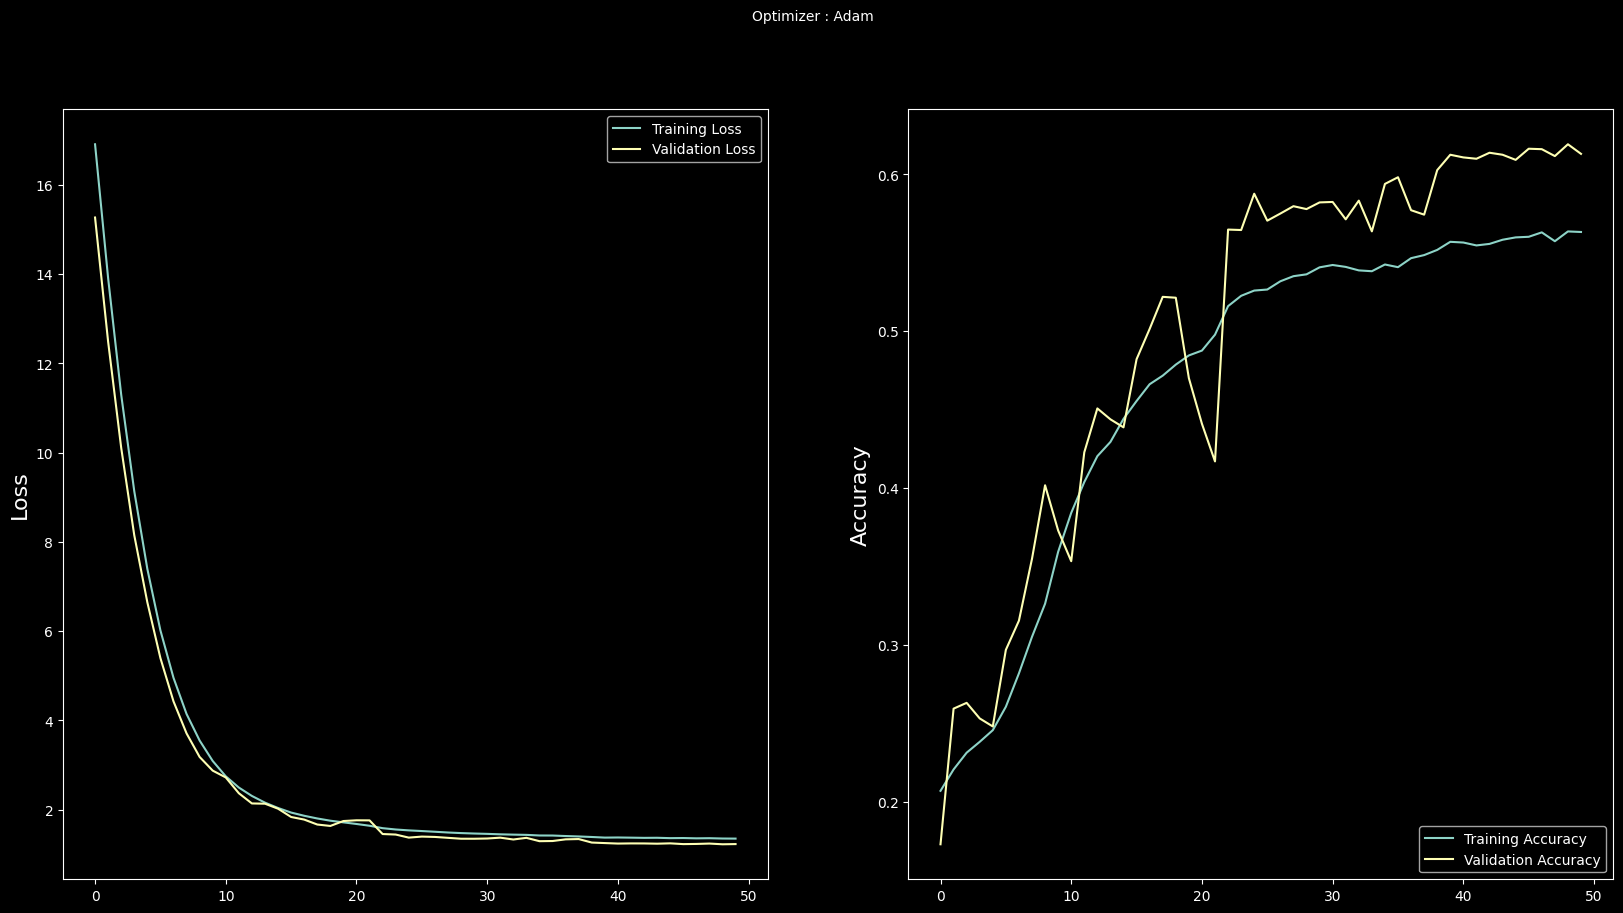

In [16]:
plt.style.use('dark_background')

# Plott som visar förlust
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Plott som visar noggrannhet
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Resultaten från plotten visar att förlusten minskar för att sedan plana ut, vilket observeras både på tränings- och valideringsdatan. Denna utveckling tyder på att modellen lär sig från data men efter ett visst antal epoker förbättras den inte väsentligt längre. Det indikerar att modellen närmar sig optimal prestanda, vilket är en normal process. När det gäller noggrannhet syns en ökande trend på både tränings- och valideringsdata vilket också pekar på att modellen lär sig bra. Dock flukturerar noggrannheten på valideringsdatan och går upp och ner vilket skulle kunna bero på överanpassning eller känslighet för variationer i valideringsdatan. Vid vidare utveckling av modellen och mer fördjupning skulle det vara viktigt att undersöka detta och identifiera samt hantera eventuella prestandaproblem.

56/56 [==============================] - 2s 37ms/step


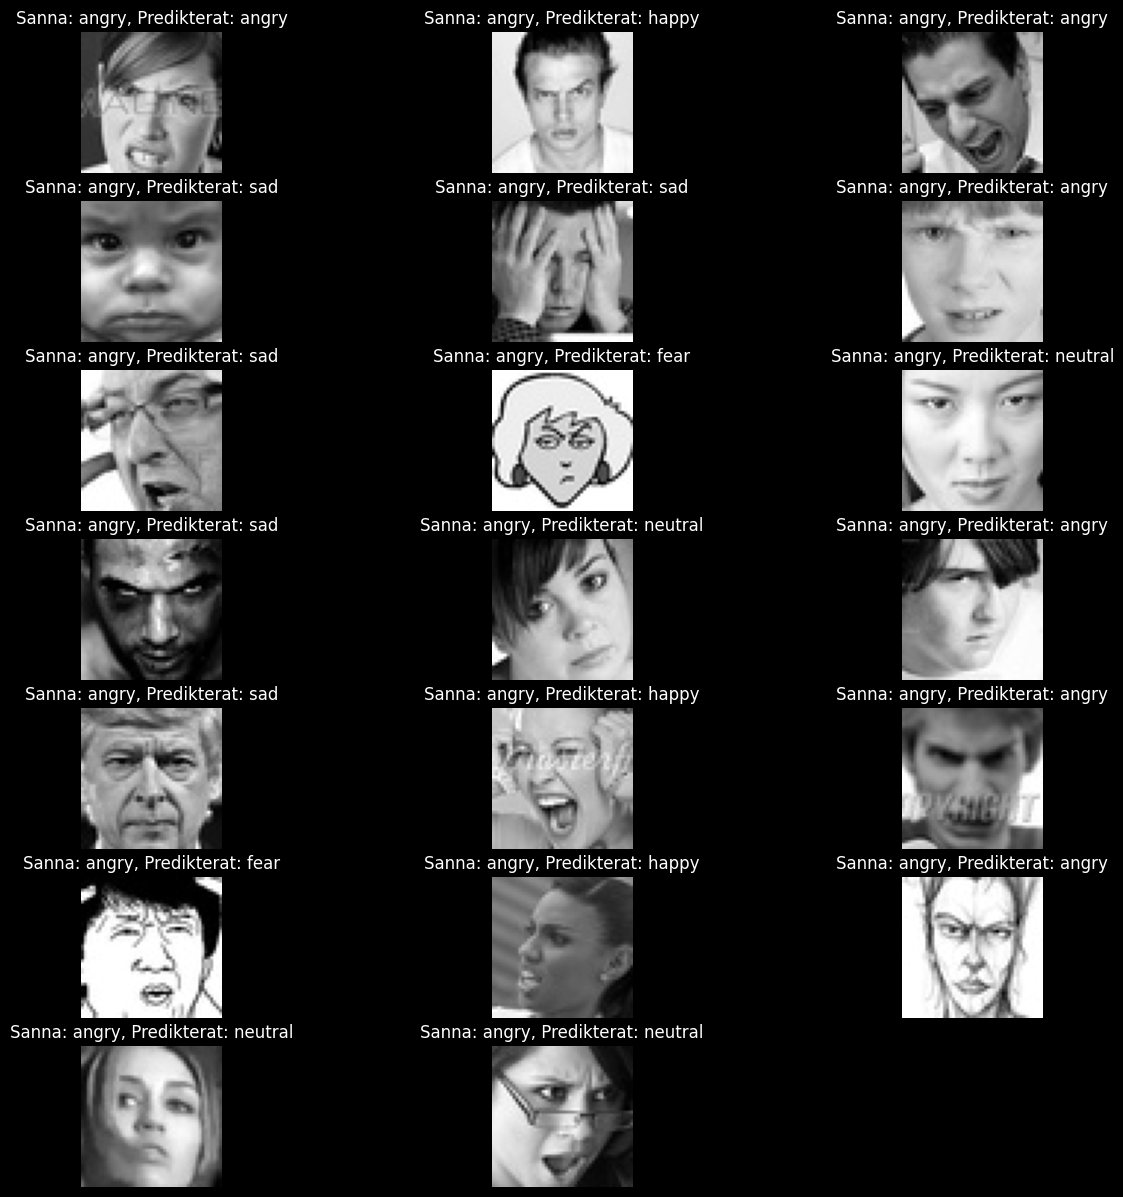

In [20]:
import random

# Prediktioner på valideringsdatan
predictions = model.predict(val_set)

# Prediktionerna konverteras till klassindikatorer
predicted_labels = np.argmax(predictions, axis=1)

# Hämta de sanna känslorna för valideringsdatan
true_labels = val_set.classes
class_names = list(val_set.class_indices.keys())

# Slumpmässigt väljs 20 index från valideringsdatan
random_indexes = random.sample(range(len(val_set)), 20)

# Visa de valda bilderna från valideringsdatan med den sanna känslan och den predikterade känslan utskrivet
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indexes):
    plt.subplot(7, 3, i+1)
    img_path = val_set.filepaths[idx]
    img = load_img(img_path, target_size=(picture_size, picture_size), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f"Sanna: {class_names[true_labels[idx]]}, Predikterat: {class_names[predicted_labels[idx]]}")
    plt.axis('off')
plt.show()

Genom ovan visualiseringar framgår det klart att kvaliteten på datasetet kanske inte är optimal. Med flera ansiktsuttryck skulle jag kunna placera en annan känsla (än den sanna) på bilden eller möjligen ha svårt att definiera en känsla överhuvudtaget. Det är tydligt att modellen inte predikterar helt korrekt på denna data.

In [22]:
from sklearn.metrics import accuracy_score

# Beräkna noggrannheten
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Modellens noggrannhet på valideringsdatan: {accuracy:.2%}')

Modellens noggrannhet på valideringsdatan: 61.34%


# 10. Insikter
Genom skapandet av Emotion Detector-modellen och dess tillämpning på bildklassificering av ansiktsuttryck har flera insikter och möjligheter framkommit.

En betydande förbättring i modellens förmåga att prediktera olika känslor uppnåddes genom användningen av dataaugmentering. Det upptäcktes att modellen presterade bäst när den kunde observera specifika ansiktsdrag såsom leenden med synliga tänder och uttryck i ögonbrynens positioner.

Trots de uppnådda framstegen konstaterades det att kvaliteten på datasetet kan vara ett hinder för ytterligare förbättringar. Genom att undersöka och eventuellt balansera datan eller till och med använda andra dataset skulle modellens prestanda kunna bli bättre.

Hyperparametertuning eller transfer learning är potentiella strategier som kan utforskas för att försöka förbättra modellens prestanda. Dessutom kan en grundlig felanalys bidra till att identifiera och åtgärda svagheter i modellens prediktioner.

Den slutgiltiga Emotion Detector with Music Suggestions-applikationen löser defintivt inga världsproblem men kan detektera en känsla och ge ett låtförslag. Vidare utveckling av applikationen kan inkludera mer estetiskt tilltalande och användarvänliga funktioner. Automatisk navigering till rekommenderade spellistor baserat på detekterade känslor är ett exempel.

# 11. Självutvärdering

1. **Utmaningar du haft under arbetet samt hur du hanterat dem.**

Den allra största utmaningen i arbetet har varit att få tillgång till GPU för att effektivt träna modellen och testa nya
eventuella lösningar. Tålamodet sätts verkligen på prov när tekniken inte samarbetar. Jag har försökt att nyttja tiden och
fokusera på något annat i arbetet om jag tex inte haft tillgång till GPU eller om något inte fungerat.
   
En annan utmaning har varit att inte fastna för länge i detaljer och finesser trots det ursprungliga målet att hålla det
enkelt. Att ha en plan och att kunna gå vidare när man fastnar är avgörande, men det är inte alltid enkelt att göra just
det. Jag har försökt vara medveten om det och jobbat på.

2. **Vilket betyg du anser att du skall ha och varför.**

Jag tycker att jag efter detta arbete har nått den kunskap och färdighet som beskrivs för kraven för betyget godkänt.
    

3. **Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den**.

Ha en tydligare arbetsplan för dig själv redan från början.
   
Som nämnt ovan, om du fastnar i något - försök att komma vidare till nästa steg och gå istället tillbaka senare i mån av
tid.
   
Skriv ner mycket kommentarer, upptäckter och insikter under resans gång.